# Introduction

This is part 2 of a two part 'end-of-phase' project with Flatiron School. In the previous notebook I conducted an descriptive and inferential analysis of the dataset that I will be using in this model creation.

# Recap

In the first notebook I answered many questions both descriptive and inferential about the data within my dataset here. 
I think the question that will be most apparent in this notebook is 'Which Companies Account for the highest amount of Market Capitalization?' I will later use that question first to create a failled model and then to use as the outputs for my working model

# Table of Contents
- [Introduction](#Introduction)
- [Recap](#Recap)
- [Table of Contents](#Table-of-Contents)
- [Data Cleaning and Preprocessing](#Data-Cleaning-and-Preprocessing)
- [Shotgun Method](#Shotgun-Method)
- [Advanced Machine Learning: 35 Stocks](#Advanced-Machine-Learning:-35-Stocks)
- [Advanced Machine Learning: Single Stock Futures](#Advanced-Machine-Learning:-Single-Stock-Futures)
- [Creating The Pipeline](#Creating-The-Pipeline)
- [The Final Result](#The-Final-Result)
- [Summary](#Summary)

In [57]:
import nbformat

def generate_toc(notebook_path):
    with open(notebook_path) as f:
        nb = nbformat.read(f, as_version=4)
    
    toc = []
    for cell in nb.cells:
        if cell.cell_type == 'markdown':
            lines = cell.source.split('\n')
            for line in lines:
                if line.startswith('#'):
                    header_level = line.count('#')
                    header_text = line.replace('#', '').strip()
                    toc.append((header_level, header_text))
    
    toc_md = ['## Table of Contents']
    for level, text in toc:
        toc_md.append(f"{'    ' * (level - 1)}- [{text}](#{text.replace(' ', '-')})")
    
    return '\n'.join(toc_md)

notebook_path = 'stock model.ipynb'
toc_md = generate_toc(notebook_path)

# Print the generated TOC
# print(toc_md)

# Data Cleaning and Preprocessing

Lets begin!

Imports

In [2]:
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import yfinance as yf
from datetime import datetime, timedelta
import warnings
from math import pi
import io
warnings.filterwarnings('ignore')


In [3]:
df_stocks = pd.read_csv('data/sp500_stocks.csv')

Im going to use the data from the S&P 500 dataset simply to get the tickers my model

In [4]:
sp500_tickers = df_stocks['Symbol'].unique()
tickers = []
for x in sp500_tickers:
    tickers.append(x)

Now im using yfinance (yahoo finance api) to collect the data I want to use for shotgun method model prediction

In [5]:
# Keys you're interested in from the 'info' function
keys = ['country', 'sector', 'previousClose', 'overallRisk', 'beta', 'trailingPE', 'forwardPE', 'volume', 'marketCap',
    'enterpriseValue', 'profitMargins', 'sharesOutstanding', 'bookValue', 
    'priceToBook', 'trailingEps', 'forwardEps', 'pegRatio', 'enterpriseToRevenue',
    'enterpriseToEbitda', 'totalCash', 'totalCashPerShare', 'ebitda', 'totalDebt',
    'quickRatio', 'currentRatio', 'totalRevenue', 'debtToEquity', 'revenuePerShare', 
    'returnOnAssets', 'returnOnEquity', 'freeCashflow', 'operatingCashflow', 
    'earningsGrowth', 'revenueGrowth', 'grossMargins', 'ebitdaMargins', 
    'operatingMargins', 'trailingPegRatio'
]


# Empty list to store results
data = []

# Loop through tickers and get the specific info
for ticker in tickers:
    stock = yf.Ticker(ticker)
    info = stock.info
    # Extract the values of the keys you're interested in
    row = {key: info.get(key, None) for key in keys}
    data.append(row)

# Convert the list of dictionaries into a pandas DataFrame
df = pd.DataFrame(data)

In [6]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to both columns and replace the original ones
df['country'] = label_encoder.fit_transform(df['country'])
df['sector'] = label_encoder.fit_transform(df['sector'])


In [7]:
# Initialize the MinMaxScaler
scaler = StandardScaler()

# Columns to scale
columns_to_scale = ['previousClose', 'overallRisk', 'beta', 'trailingPE', 'forwardPE', 'volume', 'marketCap',
    'enterpriseValue', 'profitMargins', 'sharesOutstanding', 'bookValue', 
    'priceToBook', 'trailingEps', 'forwardEps', 'pegRatio', 'enterpriseToRevenue',
    'enterpriseToEbitda', 'totalCash', 'totalCashPerShare', 'ebitda', 'totalDebt',
    'quickRatio', 'currentRatio', 'totalRevenue', 'debtToEquity', 'revenuePerShare', 
    'returnOnAssets', 'returnOnEquity', 'freeCashflow', 'operatingCashflow', 
    'earningsGrowth', 'revenueGrowth', 'grossMargins', 'ebitdaMargins', 
    'operatingMargins', 'trailingPegRatio'
]

# Apply MinMaxScaler to the selected columns
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [8]:
df.dropna(inplace=True)

In [9]:
features = df.drop(columns=['previousClose'])

# Shotgun Method

This method is used to create a baseline accuracy from a number of models all at once

In [10]:
X = features
y = df['previousClose']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [12]:
def train_and_evaluate_models(models):
    metrics = {
        'R-squared': r2_score,
        'Mean Squared Error': mean_squared_error,
        'Mean Absolute Error': mean_absolute_error,
        'Explained Variance': explained_variance_score,
        'Root Mean Squared Error': root_mean_squared_error,
        'Mean Absolute Percentage Error': mean_absolute_percentage_error
    }

    results = {}

    for metric_name, metric_function in metrics.items():
        model_scores = {}
        for model in models:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            score = metric_function(y_test, y_pred)
            model_scores[str(model)] = score
        results[metric_name] = model_scores

    return results

In [13]:
models = [RandomForestRegressor(), LinearRegression(), KNeighborsRegressor()]
model_metrics = train_and_evaluate_models(models=models)

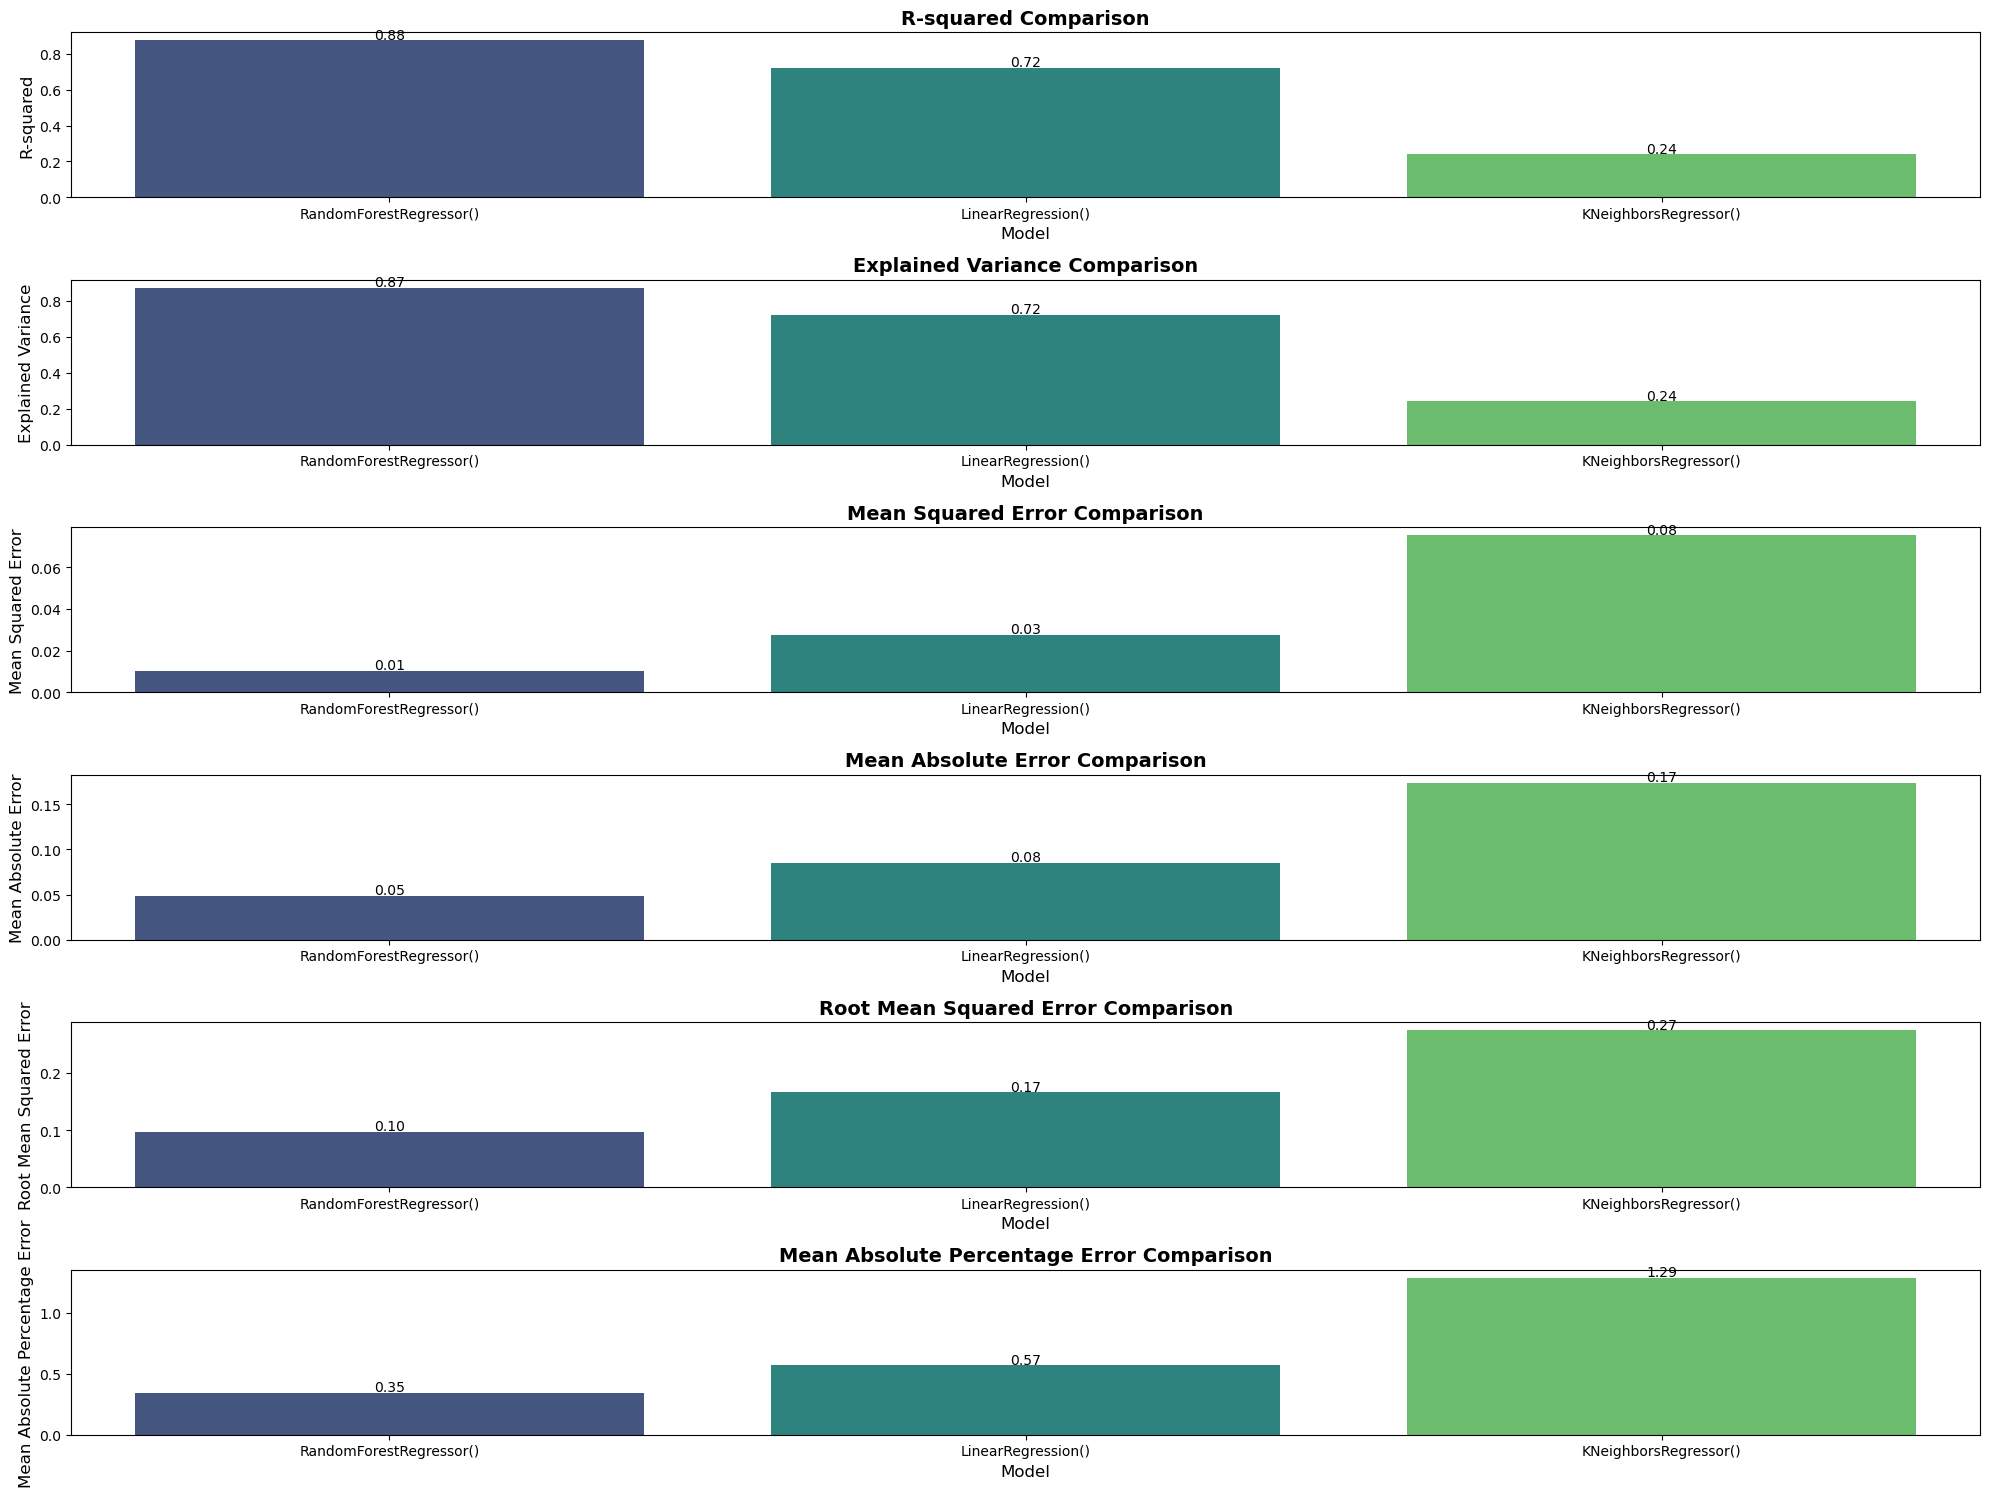

In [14]:
fig, axes = plt.subplots(6, 1, figsize=(20, 15))

# List of metric names for easier iteration
metric_names = ['R-squared', 'Explained Variance', 'Mean Squared Error', 'Mean Absolute Error', 'Root Mean Squared Error', 'Mean Absolute Percentage Error']

for i, metric_name in enumerate(metric_names):
    ax = axes[i]
    model_scores = model_metrics[metric_name]

    sns.barplot(x=list(model_scores.keys()), y=list(model_scores.values()), palette="viridis", ax=ax)

    # Add labels to the bars
    for j, score in enumerate(model_scores.values()):
        if metric_name == 'R-squared':
            ax.text(j, score + 0.01 *max(model_scores.values()), f'{score:.2f}', ha='center')
        else:
            ax.text(j, score + 0.01 * max(model_scores.values()), f'{score:.2f}', ha='center')

    # Adding labels and title
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel(metric_name, fontsize=12)
    ax.set_title(f'{metric_name} Comparison', fontsize=14, weight='bold')

# Adjust layout to prevent overlapping
plt.tight_layout()
# plt.savefig('savefig/RegressionModels.png')
plt.show()

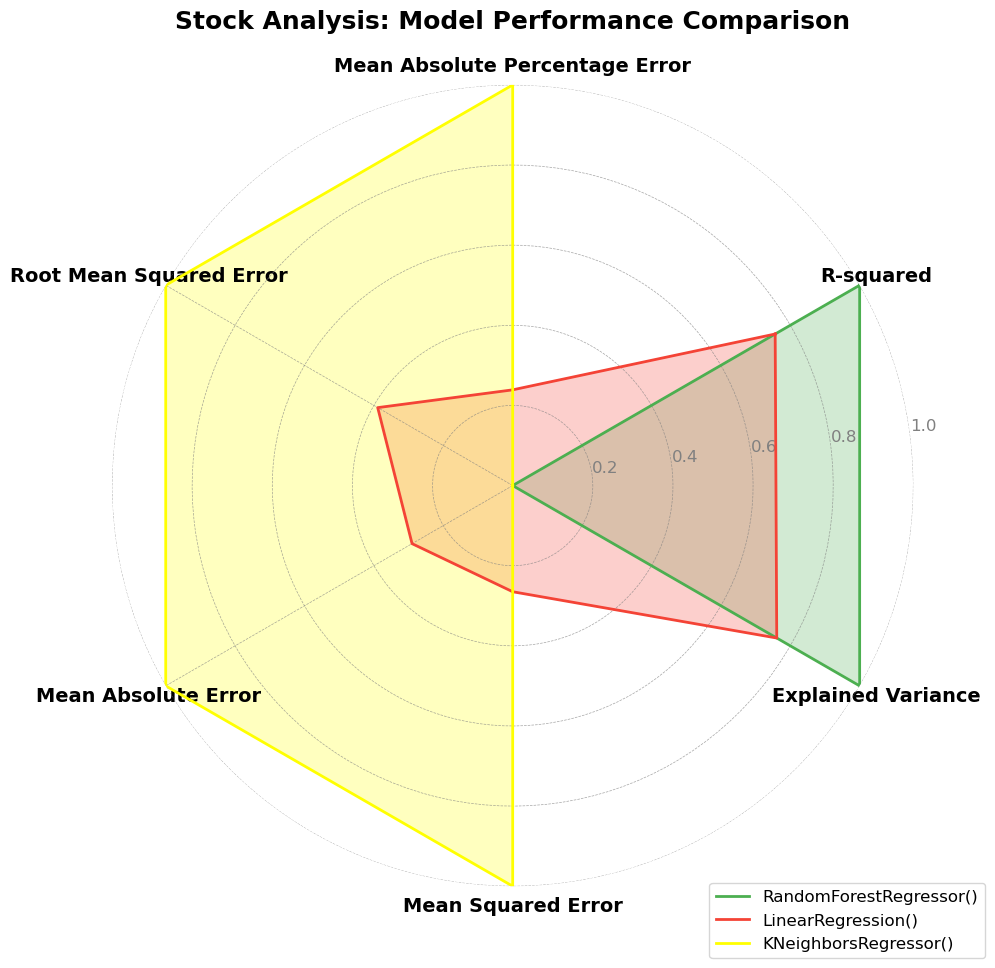

In [15]:
# Reorder the list of metric names so that 'R-squared' and 'Explained Variance' are next to each other
metric_names = ['R-squared', 'Explained Variance', 'Mean Squared Error', 'Mean Absolute Error', 'Root Mean Squared Error', 'Mean Absolute Percentage Error']

# Prepare the data for radar chart
model_names = list(next(iter(model_metrics.values())).keys())  # Get the list of model names
num_metrics = len(metric_names)

# Initialize a dictionary to hold the scaled values
scaled_model_metrics = {metric: {} for metric in metric_names}

# Apply MinMax scaling for each metric individually across models
scaler = MinMaxScaler()

for metric in metric_names:
    # Extract the scores for this metric across all models
    scores = np.array([model_metrics[metric][model] for model in model_names]).reshape(-1, 1)
    
    # Scale the scores for this metric
    scaled_scores = scaler.fit_transform(scores).flatten()
    
    # Store the scaled scores back into the dictionary
    for i, model in enumerate(model_names):
        scaled_model_metrics[metric][model] = scaled_scores[i]

# Create angles for the radar plot to form a hexagon (6 sides)
angles = [n / float(num_metrics) * 2 * pi for n in range(num_metrics)]
angles += angles[:1]  # Complete the loop

# Define the color mapping for each model with exact colors
color_mapping = {
    'RandomForestRegressor()': '#4CAF50',  # Green used previously
    'KNeighborsRegressor()': 'yellow',
    'LinearRegression()': '#F44336'  # Red used previously
}

# Create the radar plot with hexagonal grid
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Customize the hexagonal appearance by manually setting the radial ticks and limits
ax.set_theta_offset(pi / 6)  # Start the first axis at the top of the hexagon
ax.set_theta_direction(-1)   # Ensure the axes go clockwise

# Plot each model's scaled metrics with their assigned colors
for model in model_names:
    scores = [scaled_model_metrics[metric][model] for metric in metric_names]
    scores += scores[:1]  # Complete the loop for radar chart
    
    ax.plot(angles, scores, linewidth=2, linestyle='solid', label=model, color=color_mapping.get(str(model), 'blue'))
    ax.fill(angles, scores, alpha=0.25, color=color_mapping.get(str(model), 'blue'))

# Add labels for each metric at the corresponding angles
plt.xticks(angles[:-1], metric_names, color='black', size=14, weight='bold')

# Set y-ticks and y-limits for better readability (since everything is now scaled between 0 and 1)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ['0.2', '0.4', '0.6', '0.8', '1.0'], color="grey", size=12)
plt.ylim(0, 1)

# Customize the grid to have a hexagonal shape
ax.grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.7)
ax.spines['polar'].set_visible(False)

# Title and legend
plt.title('Stock Analysis: Model Performance Comparison', size=18, color='black', weight='bold', pad=20)

# Move the legend to the lower-right corner
plt.legend(loc='lower right', bbox_to_anchor=(1.1, -0.1), fontsize=12)

# Display the plot
plt.tight_layout()
plt.savefig('shotgun.png', transparent=True)
plt.show()



# Advanced Machine Learning: 35 Stocks

This was the original concept I concieved, the plan was to train the model on 35 different stocks at once and then use that model to predict new data for a stock that wasn't in the original 35, it went just about as well as it sounds

In [16]:
# List of 35 stocks with the highest market cap in respective sector
tickers = ['AAPL', 'MSFT', 'NVDA', 'AVGO', 'ORCL', 'ADBE', 'CRM', 'AMD', 'ACN', # 9 Stocks from the Technology Sector
           'BRK-B', 'JPM', 'V', 'MA', 'BAC', 'WFC', # 6 Stocks from the Financial Services Sector
           'LLY', 'UNH', 'JNJ', 'ABBV', # 4 Stocks from the Healthcare Sector
           'GE', 'CAT', 'RTX', 'UNP', # 4 Stocks from the Industrials Sector
           'AMZN', 'TSLA', 'HD', # 3 Stocks from the Consumer Cyclical Sector
           'GOOGL', 'META', 'NFLX', # 3 Stocks from the Communication Services Sector
           'WMT', 'PG', # 2 Stocks from the Consumer Defensive Sector
           'XOM', # 1 Stock from the Energy Sector
           'PLD', # 1 Stock from the Real Estate Sector
           'NEE', # 1 Stock from the Utilities Sector
           'LIN' # 1 Stock from the Basic Materials Sector
]

In [17]:
# Define the end date as yesterday
end_date = datetime.now() - timedelta(1)
end_date_str = end_date.strftime('%Y-%m-%d')

In [18]:
stock_data = pd.DataFrame()
for ticker in tickers:
    df = yf.download(ticker, start="2014-01-01", end=end_date_str)
    df['Ticker'] = ticker
    stock_data = pd.concat([stock_data, df])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [19]:
# Select and pivot the data
stock_data = stock_data[['Ticker', 'Adj Close']]
stock_data = stock_data.pivot_table(index=stock_data.index, columns='Ticker', values='Adj Close')

In [20]:
# Scaling my data
scaler = MinMaxScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(stock_data), columns=stock_data.columns, index=stock_data.index)

In [21]:
# Define time step
time_step = 60

# Create sequences
X_train, y_train = [], []
for i in range(len(scaled_data) - time_step):
    X_train.append(scaled_data.iloc[i:i+time_step].values)
    y_train.append(scaled_data.iloc[i + time_step].values)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Display the shapes of X_train and y_train
X_train.shape, y_train.shape

((2631, 60, 35), (2631, 35))

In [22]:
num_samples, time_steps, num_stocks = X_train.shape

# Reshape the training data to (num_samples * num_stocks, 1, time_steps, num_features)
X_train_reshaped = X_train.reshape(-1, 1, time_steps)
y_train_reshaped = y_train.reshape(-1)  # Adjust labels accordingly

In [23]:
X_train_reshaped.shape, y_train_reshaped.shape

((92085, 1, 60), (92085,))

In [24]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(1, time_steps)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1))

optimizer = Adam(learning_rate=0.0000001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 100)            64400     
                                                                 
 dropout (Dropout)           (None, 1, 100)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 1, 200)           160800    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 1, 200)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 1, 200)           240800    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 1, 200)            0

i commented the fitting of my model as the best model has been saved and I wont accidentally spend the time retraining it

In [25]:
# # Early stopping callback
# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # Train the model with the checkpoint
# history = model.fit(X_train_reshaped, y_train_reshaped, epochs=50, batch_size=10, validation_split=0.2, shuffle=False, callbacks=[early_stop])

In [26]:
# model.save('best_model.h5')

In [27]:
model= load_model('best_model.h5')

In [28]:
def stock_prediction(test_ticker):
    # Load test stock data
    test_stock = pd.DataFrame()
    df = yf.download(test_ticker, start="2014-01-01", end=end_date_str)
    df['Ticker'] = test_ticker
    test_stock = pd.concat([test_stock, df])

    # Select and pivot the test data
    test_stock = test_stock[['Ticker', 'Adj Close']]
    test_stock = test_stock.pivot_table(index=test_stock.index, columns='Ticker', values='Adj Close')

    # Scaling the test data
    scaler = MinMaxScaler()
    scaled_test_data = pd.DataFrame(scaler.fit_transform(test_stock), columns=test_stock.columns, index=test_stock.index)

    # Create sequences
    X_test, y_test = [], []
    for i in range(len(scaled_test_data) - time_step):
        X_test.append(scaled_test_data.iloc[i:i + time_step].values)
        y_test.append(scaled_test_data.iloc[i + time_step].values)

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # Reshape the test data
    X_test_reshaped = X_test.reshape(-1, 1, time_step)
    y_test_reshaped = y_test.reshape(-1)

    # Make predictions
    predictions = model.predict(X_test_reshaped)

    # Plot the predictions vs actual stock prices starting from the 2000th sample
    plt.plot(y_test_reshaped[2455:], label='Actual Stock Prices')
    plt.plot(predictions[2455:], label='Predicted Stock Prices', linestyle='--')
    plt.legend()
    plt.title(f'Stock Price Prediction vs Actual for {test_ticker}')
    plt.show()

[*********************100%***********************]  1 of 1 completed


83/83 [==============================] - 4s 2ms/step


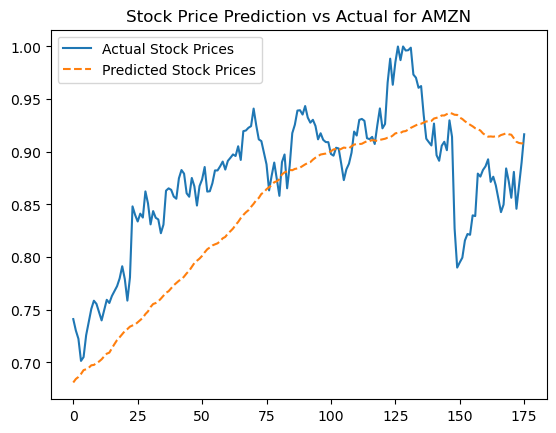

In [29]:
stock_prediction('AMZN')

as you can see, the results were not good

____________

# Advanced Machine Learning: Single Stock Futures

In [30]:
# Define the end date as yesterday
end_date = datetime.now() - timedelta(1)
end_date_str = end_date.strftime('%Y-%m-%d')

In [31]:
# Define the start date as a year before yesterday
start_date = end_date - timedelta(1825)
start_date_str = start_date.strftime('%Y-%m-%d')

In [32]:
# Download stock data
stock_data = yf.download('WM', start=start_date_str, end=end_date_str)

# Scaling
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(stock_data['Close'].values.reshape(-1,1))

[*********************100%***********************]  1 of 1 completed


In [33]:
time_step = 7

In [34]:
# Define the model
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(time_step, 1)))
model.add(Bidirectional(LSTM(units=64)))
model.add(Dense(units=64))
model.add(Dropout(0.5))
model.add(Dense(units=1))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 7, 64)             16896     
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 91,265
Trainable params: 91,265
Non-trainable params: 0
__________________________________________________

In [35]:
# Step 1: Predict today’s data
todays_data = scaled_data[-time_step:].reshape(1, time_step, 1)
todays_prediction = model.predict(todays_data)
todays_prediction_inversed = scaler.inverse_transform(todays_prediction)
todays_prediction_inversed

1/1 [==============================] - 1s 1s/step


array([[148.81094]], dtype=float32)

In [36]:
# Step 2: Append today’s prediction to the dataset
new_data_point = np.append(stock_data['Close'].values, todays_prediction_inversed)

# Recreate scaled_data based on the updated dataset
updated_scaled_data = scaler.fit_transform(new_data_point.reshape(-1, 1))

In [37]:
# Recreate X and y with the updated dataset
X_new, y_new = [], []
for i in range(len(updated_scaled_data) - time_step - 1):
    X_new.append(updated_scaled_data[i:(i + time_step), 0])  # Add time_step-length sequences to X
    y_new.append(updated_scaled_data[i + time_step, 0])      # Add the next value to y

X_new = np.array(X_new)
y_new = np.array(y_new)
X_new = np.reshape(X_new, (X_new.shape[0], X_new.shape[1], 1))

In [38]:
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Learning rate reducer callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-10, verbose=1)

# Train the model with the checkpoint
history = model.fit(X_new, y_new, epochs=100, batch_size=10, validation_split=0.2, shuffle=False, callbacks=[early_stop, reduce_lr])

Epoch 1/100
100/100 [==============================] - 9s 20ms/step - loss: 0.0288 - val_loss: 0.0999 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0184 - val_loss: 0.0484 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0137 - val_loss: 0.0105 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 1s 6ms/step - loss: 0.0094 - val_loss: 0.0041 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 1s 6ms/step - loss: 0.0078 - val_loss: 0.0047 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0068 - val_loss: 0.0048 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0069 - val_loss: 0.0055 - lr: 0.0010
Epoch 8/100
100/100 [==============================] - 1s 7ms/step - loss: 0.0071 - val_loss: 0.0053 - lr: 0.0010
Epoch 9/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0072
Epoch 9: 

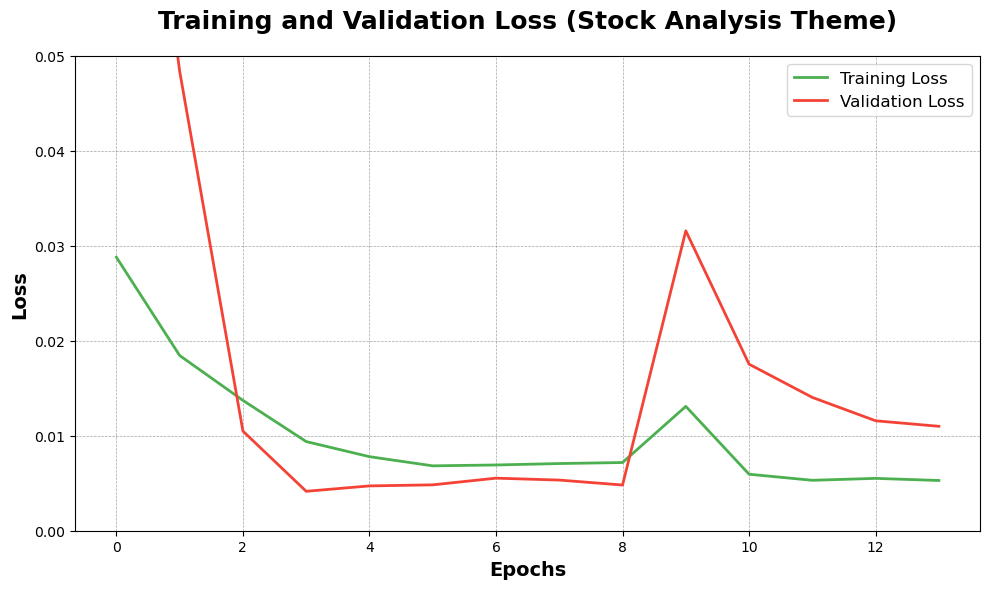

In [39]:
# Plot the training loss and validation loss with stock analysis theme
plt.figure(figsize=(10, 6))

# Plot training loss in green (typically for "positive" improvement)
plt.plot(history.history['loss'], label='Training Loss', color='#4CAF50', linewidth=2)

# Plot validation loss in red (for validation, possibly showing "issues")
plt.plot(history.history['val_loss'], label='Validation Loss', color='#F44336', linewidth=2)

# Set title and labels
plt.title('Training and Validation Loss (Stock Analysis Theme)', fontsize=18, weight='bold', pad=20)
plt.xlabel('Epochs', fontsize=14, weight='bold')
plt.ylabel('Loss', fontsize=14, weight='bold')

# Set y-axis limits from 0 to 0.05 as requested
plt.ylim(0, 0.05)

# Add grid lines for better readability
plt.grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.7)

# Customize the legend and display it in the lower right corner
plt.legend(loc='upper right', fontsize=12)

# Clean and polished layout
plt.tight_layout()

# Show the plot
plt.savefig('Loss.png', transparent= True)
plt.show()



In [40]:
# Make new predictions after retraining
predictions = model.predict(X_new)
predictions = scaler.inverse_transform(predictions)
print(f'Predicted Close: {predictions[-1:]}')
print(f"Actual Close: {stock_data['Close'][-1:].values}")

40/40 [==============================] - 0s 2ms/step
Predicted Close: [[208.76282]]
Actual Close: [207.63999939]


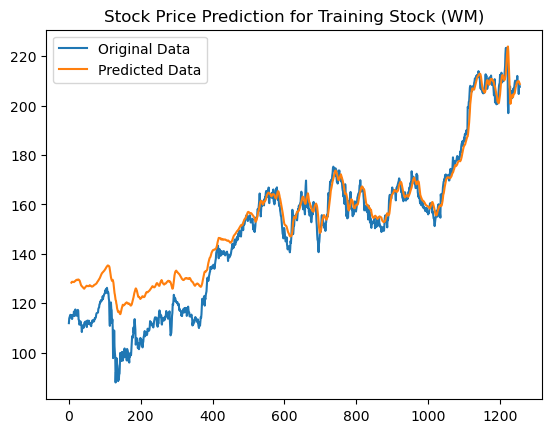

In [41]:
# Collect data for the plot
original_data = stock_data['Close'].values
predicted_data = np.empty_like(original_data)
predicted_data[:] = np.nan
predicted_data[-len(predictions):] = predictions.reshape(-1)

# Create the plot
fig, ax = plt.subplots()
ax.plot(original_data, label='Original Data')
ax.plot(predicted_data, label='Predicted Data')
ax.legend()

plt.title(f"Stock Price Prediction for Training Stock (WM)")
plt.show()

In [42]:
# Initialize the data with the last `time_step` days from the initial_data
initial_data = scaled_data[-7:]
current_window = initial_data[-time_step:].copy()  # Assuming `initial_data` is already defined
all_predictions = []

for i in range(30):
    # Reshape current_window to match the model input shape (assuming a 3D input for LSTM)
    X_input = current_window.reshape((1, time_step, current_window.shape[1]))

    # Generate multiple predictions (ensemble) for the current day
    ensemble_predictions = []
    for _ in range(15):
        predicted_value = model.predict(X_input)[0][0]  # Assuming a single output per prediction
        ensemble_predictions.append(predicted_value)

    # Calculate the mean of the ensemble predictions
    predicted_value = np.mean(ensemble_predictions)

    # Append the prediction to the list of predictions
    all_predictions.append(predicted_value)

    # Update the current window with the new predicted value
    # We assume here that we're predicting a single feature, like the "Close" price
    predicted_value_as_array = np.array([[predicted_value]])
    current_window = np.vstack([current_window[1:], predicted_value_as_array])

1/1 [==============================] - 0s 16ms/step


In [43]:
# Convert predictions back to original scale (if using a scaler)
predicted_prices = scaler.inverse_transform(np.array(all_predictions).reshape(-1, 1))

# Optionally: Plot or use these predictions as needed
print("Predicted Prices for the next 14 days (using ensemble averaging):", predicted_prices)

Predicted Prices for the next 14 days (using ensemble averaging): [[207.97527]
 [207.69579]
 [207.42749]
 [207.29591]
 [207.7851 ]
 [207.62437]
 [207.5071 ]
 [207.4927 ]
 [207.41284]
 [207.37335]
 [207.3719 ]
 [207.38762]
 [207.31448]
 [207.26453]
 [207.22813]
 [207.18695]
 [207.1525 ]
 [207.11801]
 [207.07718]
 [207.0268 ]
 [206.98174]
 [206.93758]
 [206.89188]
 [206.8454 ]
 [206.79678]
 [206.74591]
 [206.69359]
 [206.64117]
 [206.58757]
 [206.53241]]


In [44]:
# # Number of days to zoom in on
# zoom_days = 730

# # Create a timeline for the final `zoom_days` of the actual data and original predictions
# days = np.arange(len(original_data))[-zoom_days:]  # Last `zoom_days` days for the actual data
# predicted_days = np.arange(len(original_data))[-zoom_days:]  # Adjust for the predicted data's timeline
# future_days = np.arange(len(original_data), len(original_data) + len(predicted_prices))  # Future timeline

# plt.figure(figsize=(10, 6))

# # Plot last `zoom_days` of actual data in blue
# plt.plot(days, original_data[-zoom_days:], label='Actual Data', color='blue')

# # Plot last `zoom_days` of original predictions in orange
# plt.plot(predicted_days, predicted_data[-zoom_days:], label='Predicted Data', color='orange')

# # Plot future predictions in green after the dotted line
# plt.plot(future_days, predicted_prices, label='Future Predicted Data', color='green')

# # Add a vertical dotted line at the point where the future predictions start
# plt.axvline(x=len(original_data) - 1, color='black', linestyle='--', label='Prediction Boundary')

# # Add labels and title
# plt.xlabel('Days')
# plt.ylabel('Stock Price')
# plt.title('Stock Price Prediction for Stock')

# # Show legend
# plt.legend()

# # Show plot
# plt.show()

In [45]:
noise_factor = 0.02
initial_data = scaled_data[-7:]
current_window = initial_data[-time_step:].copy()  # Assuming `initial_data` is already defined
noisy_predictions = []

for i in range(30):
    X_input = current_window.reshape((1, time_step, current_window.shape[1]))

    ensemble_predictions = []
    for _ in range(15):
        predicted_value = model.predict(X_input)[0][0]
        ensemble_predictions.append(predicted_value)

    # Calculate the mean of the ensemble predictions
    predicted_value = np.mean(ensemble_predictions)

    # Add random noise to introduce variance
    predicted_value += noise_factor * np.random.randn()

    noisy_predictions.append(predicted_value)

    predicted_value_as_array = np.array([[predicted_value]])
    current_window = np.vstack([current_window[1:], predicted_value_as_array])

1/1 [==============================] - 0s 17ms/step


In [46]:
# Convert predictions back to original scale (if using a scaler)
predicted_prices = scaler.inverse_transform(np.array(noisy_predictions).reshape(-1, 1))

# Optionally: Plot or use these predictions as needed
print("Predicted Prices for the next 14 days (using ensemble averaging):", predicted_prices)

Predicted Prices for the next 14 days (using ensemble averaging): [[206.9749627 ]
 [208.364777  ]
 [207.69948994]
 [207.37926336]
 [203.57838716]
 [207.56803575]
 [206.02246478]
 [205.99270564]
 [205.12475882]
 [205.72914817]
 [207.39012355]
 [205.54218722]
 [202.97661714]
 [207.79488951]
 [202.45196959]
 [203.87972648]
 [205.37233854]
 [206.43699131]
 [204.39886884]
 [203.71280882]
 [207.08200002]
 [202.99952227]
 [205.76681022]
 [204.70464947]
 [205.62861474]
 [203.14258957]
 [205.56741431]
 [204.1310381 ]
 [203.18284465]
 [201.99510227]]


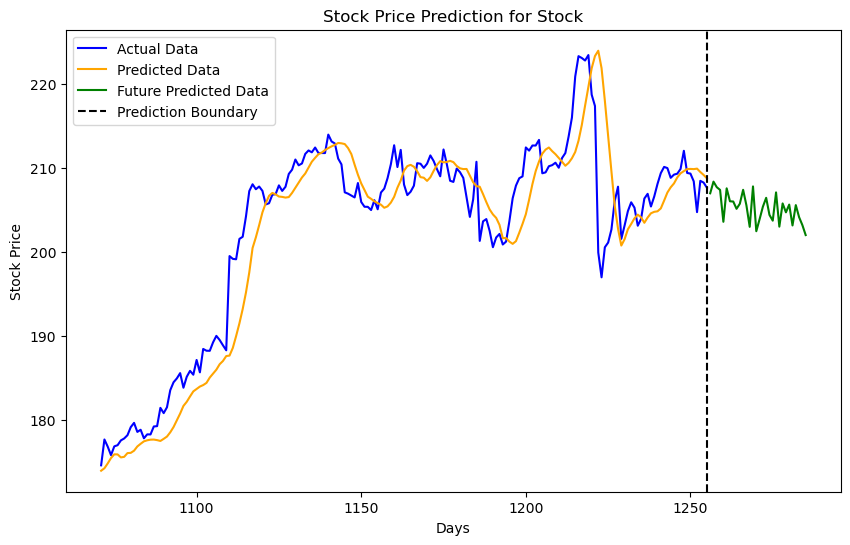

In [47]:
# Number of days to zoom in on
zoom_days = 185

# Create a timeline for the final `zoom_days` of the actual data and original predictions
days = np.arange(len(original_data))[-zoom_days:]  # Last `zoom_days` days for the actual data
predicted_days = np.arange(len(original_data))[-zoom_days:]  # Adjust for the predicted data's timeline
future_days = np.arange(len(original_data), len(original_data) + len(predicted_prices))  # Future timeline

plt.figure(figsize=(10, 6))

# Plot last `zoom_days` of actual data in blue
plt.plot(days, original_data[-zoom_days:], label='Actual Data', color='blue')

# Plot last `zoom_days` of original predictions in orange
plt.plot(predicted_days, predicted_data[-zoom_days:], label='Predicted Data', color='orange')

# Plot future predictions in green after the dotted line
plt.plot(future_days, predicted_prices, label='Future Predicted Data', color='green')

# Add a vertical dotted line at the point where the future predictions start
plt.axvline(x=len(original_data) - 1, color='black', linestyle='--', label='Prediction Boundary')

# Add labels and title
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction for Stock')

# Show legend
plt.legend()

# Show plot
plt.show()

This process on the otherhand came out REALLY WELL!!

_____________________

# Creating The Pipeline

now that I know my model works and it is performing successfully, i combined all the steps into 1 function

In [48]:
def pipeline(ticker):
    # Define the end date as yesterday
    end_date = datetime.now() - timedelta(1)
    end_date_str = end_date.strftime('%Y-%m-%d')

    # Define the start date as 5 years before yesterday
    start_date = end_date - timedelta(1825)
    start_date_str = start_date.strftime('%Y-%m-%d')

    # Define the directory path
    directory = f'Stock Graphs/{ticker}'

    # Check if the directory exists, and create it if it doesn't
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # Download stock data
    stock_data = yf.download(ticker, start=start_date_str, end=end_date_str)

    # Scaling
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(stock_data['Close'].values.reshape(-1,1))

    time_step = 7

    # Define the model
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=True, input_shape=(time_step, 1)))
    model.add(Bidirectional(LSTM(units=64)))
    model.add(Dense(units=64))
    model.add(Dropout(0.5))
    model.add(Dense(units=1))

    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Step 1: Predict today’s data
    todays_data = scaled_data[-time_step:].reshape(1, time_step, 1)
    todays_prediction = model.predict(todays_data)
    todays_prediction_inversed = scaler.inverse_transform(todays_prediction)
    todays_prediction_inversed

    # Step 2: Append today’s prediction to the dataset
    new_data_point = np.append(stock_data['Close'].values, todays_prediction_inversed)

    # Recreate scaled_data based on the updated dataset
    updated_scaled_data = scaler.fit_transform(new_data_point.reshape(-1, 1))

    # Recreate X and y with the updated dataset
    X_new, y_new = [], []
    for i in range(len(updated_scaled_data) - time_step - 1):
        X_new.append(updated_scaled_data[i:(i + time_step), 0])  # Add time_step-length sequences to X
        y_new.append(updated_scaled_data[i + time_step, 0])      # Add the next value to y

    X_new = np.array(X_new)
    y_new = np.array(y_new)
    X_new = np.reshape(X_new, (X_new.shape[0], X_new.shape[1], 1))

    # Early stopping callback
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Learning rate reducer callback
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-10, verbose=1)

    # Train the model with the checkpoint
    model.fit(X_new, y_new, epochs=100, batch_size=10, validation_split=0.2, shuffle=False, callbacks=[early_stop, reduce_lr])

    # Make new predictions after retraining
    predictions = model.predict(X_new)
    predictions = scaler.inverse_transform(predictions)
    print(f'Predicted Close: {predictions[-1:]}')
    print(f"Actual Close: {stock_data['Close'][-1:].values}")

    # Collect data for the plot
    original_data = stock_data['Close'].values
    predicted_data = np.empty_like(original_data)
    predicted_data[:] = np.nan
    predicted_data[-len(predictions):] = predictions.reshape(-1)

    # Historical data plot with prediction
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(original_data, label='Original Data', color='blue', linewidth=2)
    ax.plot(predicted_data, label='Predicted Data', color='orange', linewidth=2)

    # Add labels and title with bold, larger fonts
    ax.set_title(f'Stock Price Prediction for {ticker}', fontsize=18, weight='bold', pad=20)
    ax.set_xlabel('Days', fontsize=14, weight='bold')
    ax.set_ylabel('Stock Price', fontsize=14, weight='bold')

    # Add a grid and legend
    ax.grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.legend(loc='lower right', fontsize=12)

    plt.savefig(f'{directory}/historical.png')
    plt.close()

    # Initialize the data with the last `time_step` days from the initial_data
    initial_data = scaled_data[-7:]
    current_window = initial_data[-time_step:].copy()  # Assuming `initial_data` is already defined
    all_predictions = []

    for i in range(30):
        # Reshape current_window to match the model input shape (assuming a 3D input for LSTM)
        X_input = current_window.reshape((1, time_step, current_window.shape[1]))

        # Generate multiple predictions (ensemble) for the current day
        ensemble_predictions = []
        for _ in range(15):
            predicted_value = model.predict(X_input)[0][0]  # Assuming a single output per prediction
            ensemble_predictions.append(predicted_value)

        # Calculate the mean of the ensemble predictions
        predicted_value = np.mean(ensemble_predictions)

        # Append the prediction to the list of predictions
        all_predictions.append(predicted_value)

        # Update the current window with the new predicted value
        # We assume here that we're predicting a single feature, like the "Close" price
        predicted_value_as_array = np.array([[predicted_value]])
        current_window = np.vstack([current_window[1:], predicted_value_as_array])

    # Convert predictions back to original scale (if using a scaler)
    predicted_prices = scaler.inverse_transform(np.array(all_predictions).reshape(-1, 1))

    # Number of days to zoom in on
    zoom_days = 730

    # Create a timeline for the final `zoom_days` of the actual data and original predictions
    days = np.arange(len(original_data))[-zoom_days:]  # Last `zoom_days` days for the actual data
    predicted_days = np.arange(len(original_data))[-zoom_days:]  # Adjust for the predicted data's timeline
    future_days = np.arange(len(original_data), len(original_data) + len(predicted_prices))  # Future timeline


    # Future predictions plot
    plt.figure(figsize=(10, 6))
    plt.plot(days, original_data[-zoom_days:], label='Actual Data', color='blue', linewidth=2)
    plt.plot(predicted_days, predicted_data[-zoom_days:], label='Predicted Data', color='orange', linewidth=2)
    plt.plot(future_days, predicted_prices, label='Future Predicted Data', color='#4CAF50', linewidth=2)  # Green color for future predictions

    # Add a vertical dotted line at the point where the future predictions start
    plt.axvline(x=len(original_data) - 1, color='black', linestyle='--', label='Prediction Boundary')

    # Add labels and title with bold fonts
    plt.title(f'Stock Price Prediction for {ticker}', fontsize=18, weight='bold', pad=20)
    plt.xlabel('Days', fontsize=14, weight='bold')
    plt.ylabel('Stock Price', fontsize=14, weight='bold')

    # Add grid and legend
    plt.grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend(loc='lower right', fontsize=12)

    plt.savefig(f'{directory}/future.png')
    plt.close()

    noise_factor = 0.02  # Adjust this factor to control the level of noise
    initial_data = scaled_data[-7:]
    current_window = initial_data[-time_step:].copy()  # Assuming `initial_data` is already defined
    noisy_predictions = []

    for i in range(30):
        X_input = current_window.reshape((1, time_step, current_window.shape[1]))

        ensemble_predictions = []
        for _ in range(15):
            predicted_value = model.predict(X_input)[0][0]
            ensemble_predictions.append(predicted_value)

        # Calculate the mean of the ensemble predictions
        predicted_value = np.mean(ensemble_predictions)

        # Add random noise to introduce variance
        predicted_value += noise_factor * np.random.randn()

        noisy_predictions.append(predicted_value)

        predicted_value_as_array = np.array([[predicted_value]])
        current_window = np.vstack([current_window[1:], predicted_value_as_array])

    # Convert predictions back to original scale (if using a scaler)
    predicted_prices = scaler.inverse_transform(np.array(noisy_predictions).reshape(-1, 1))

    # Number of days to zoom in on
    zoom_days = 185

    # Create a timeline for the final `zoom_days` of the actual data and original predictions
    days = np.arange(len(original_data))[-zoom_days:]  # Last `zoom_days` days for the actual data
    predicted_days = np.arange(len(original_data))[-zoom_days:]  # Adjust for the predicted data's timeline
    future_days = np.arange(len(original_data), len(original_data) + len(predicted_prices))  # Future timeline

    # Noisy future predictions plot
    plt.figure(figsize=(10, 6))
    plt.plot(days, original_data[-zoom_days:], label='Actual Data', color='blue', linewidth=2)
    plt.plot(predicted_days, predicted_data[-zoom_days:], label='Predicted Data', color='orange', linewidth=2)
    plt.plot(future_days, predicted_prices, label='Future Predicted Data', color='#4CAF50', linewidth=2)  # Green color for future predictions

    # Add a vertical dotted line at the point where the future predictions start
    plt.axvline(x=len(original_data) - 1, color='black', linestyle='--', label='Prediction Boundary')

    # Add labels and title with bold fonts
    plt.title(f'Future Stock Price Prediction for {ticker}', fontsize=18, weight='bold', pad=20)
    plt.xlabel('Days', fontsize=14, weight='bold')
    plt.ylabel('Stock Price', fontsize=14, weight='bold')

    # Add grid and legend
    plt.grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend(loc='lower right', fontsize=12)

    plt.savefig(f'{directory}/noisy_future.png')
    plt.close()

testing the function

In [50]:
# #test
# pipeline('WM')

IT WORKS!!!

_________

# The Final Result

In [51]:
# List of 35 stocks with the highest market cap in respective sector
tickers = ['AAPL', 'MSFT', 'NVDA', 'AVGO', 'ORCL', 'ADBE', 'CRM', 'AMD', 'ACN', # 9 Stocks from the Technology Sector
           'BRK-B', 'JPM', 'V', 'MA', 'BAC', 'WFC', # 6 Stocks from the Financial Services Sector
           'LLY', 'UNH', 'JNJ', 'ABBV', # 4 Stocks from the Healthcare Sector
           'GE', 'CAT', 'RTX', 'UNP', # 4 Stocks from the Industrials Sector
           'AMZN', 'TSLA', 'HD', # 3 Stocks from the Consumer Cyclical Sector
           'GOOGL', 'META', 'NFLX', # 3 Stocks from the Communication Services Sector
           'WMT', 'PG', # 2 Stocks from the Consumer Defensive Sector
           'XOM', # 1 Stock from the Energy Sector
           'PLD', # 1 Stock from the Real Estate Sector
           'NEE', # 1 Stock from the Utilities Sector
           'LIN' # 1 Stock from the Basic Materials Sector
]

In [53]:
# for ticker in tickers:
#     pipeline(ticker)

# Summary

This is a summary of my entire modeling notebook from start to finish.


## Step 1: Data Acquistion

The most simple step of my process. Using the S&P 500 Data, I was able to collect the tickers that I wanted to use for the modeling process. After that the S&P 500 data can be put away as the rest of my dat wwas collected via the yahoo finance API `yfinance`

## Step 2: Shotgun Method

Now that we have the data, lets perform some base line models and get a starting accuracy that we can eventually work our way up with. 

Introduction the shotgun method, the shotgun method is simply using a number of different basic machine learning models to preform relatively simple task. For my model, I used 3 different regression based models, RandomForestsRegressor, KNeighborsRegressor and LinearRegression. With these 3 models I established a base from which to work up from.

Although, this is also where my work with basic machine learning models comes to an end for this notebook, while I was able to get good a good base accuracy from the RandomForestsRegressor, that model won't help me predict new data (unsupervised learning) so from here I move onto deep learning and neural networks


## Step 3: Building a Neural Network

Obviously, if you read through the entire notebook you'd know that there was a lot in between the shotgun method and my working neural network but we dont have to go over that as its not related to the final result.

So the first thing to do is get your data, for me when building the model, I used Waste Management's stock WM. Now that you hav ethe historical stock data, next thing to do is scale the data so that the your model can read and predict upon it a little easier.

Once you have your data and have it scaled then starts the actual model building process. I decided to use a 5 layer model, these were my layers
- **LSTM (64 Units)**: This was my input layer, LSTMs are really useful for very noisy historical data which is exactly why I'm using two of them
- **Bidirectional LSTM (64 Units)**: The was the first 'hidden layer' in my model the idea was to continue the process sent by the input layer and then also include the bidirectional which can increase the models understanding of the data
- **Dense (64 Units)**: this was the lead into my output, To be completely honest, I'm not exactly sure why I initially added it to my model, but it worked and I wasnt going to take it out now
- **Droupout (0.5)**: Next I added a dropout layer to ideally reduce overfitting and allowed the model to get closer and closer to a well-fit model.
- **Dense (1 Unit)**: Lastly the output layer, simpley put, its time to condense all of the models results into a single number and that is exact what this layer did

Now that we have our model built, its time to train. For training I used 100 epochs and both early stopping and a learning rate reducer to acheive a well fit model. 

After fitting the model I wanted to see how close the model's predictions were to the actual stock data. So I created those predictions and grpahed them to visualize. They were looking very good so I continued on to the predictions for future stock data. 

I was able to achieve the future predictions using a rolling window. Basically the idea was that for each predicted value (1 day worth of stock in the future), the model will add that to its data that it uses to predict the next days stock. This made it so that I was able to predict however far into the future I would like and it wouldn't just continue looking at the same data.

## Step 4: Putting it All Together

Now that I have my model build and ready, the next and final step will be to create a function that can run the process from start to finish just by a push of a button, which is exactly what I did. 

# Conclusion:

This was a very difficult but real project, meaning this project had very real world implications that wouldnt just be that another bootcamp student did another project. If I was able to perfect this model, I would become a very rich person. That being said, my model isn't perfect. There is a lot of room for improvement when it comes to this project. 

All that aside, I still feel like I accomplished my goal of proving that a deep learning model can understand the trend and patterns of stock data and create semi-realistic predictions for how the stock market may continue to act in the near future.

Ideally, I would love to continue this project with more data and other daily metrics that would be feasable to use in a model like this.

Overall, I believe this project is not completed to its fullest and there is still much to be done before it this model is ready for real world implementation